<a href="https://colab.research.google.com/github/ivelin/canswim/blob/main/canswim_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an experimental attempt to implement growth stock indicators in support of CANSLIM style investors and traders.

## Prepare Environment

Jupyter notebook housekeeping

In [1]:

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline


### Install local canswim package

In [2]:
# pip install -r requirements.txt
# !pip install -e ./

import sys
!{sys.executable} -m pip install -e ./


Obtaining file:///home/ivelin/canswim
  Preparing metadata (setup.py) ... done
  Attempting uninstall: canswim
    Found existing installation: canswim 0.0.1
    Uninstalling canswim-0.0.1:
      Successfully uninstalled canswim-0.0.1
  Running setup.py develop for canswim


## Prepare Model

In [3]:
from canswim.model import CanswimModel

canswim_model = CanswimModel()

canswim_model.load_data()


n_test_range_days: 630
min_samples: 1890
n_stocks:  50
n_epochs:  10
Configuring CUDA GPU
earnings_loaded_df.columns Index(['symbol', 'date', 'eps', 'epsEstimated', 'time', 'revenue',
       'revenueEstimated', 'updatedFromDate', 'fiscalDateEnding'],
      dtype='object')


In [4]:
# canswim_model.covariates.load_past_covariates()
# canswim_model.covariates.load_future_covariates()

In [5]:

def prepare_data():
    canswim_model.prepare_data()
    canswim_model.plot_splits()
    canswim_model.plot_seasonality()



Training loop stock subset: ['BXMT', 'BZH', 'LWLG', 'STLD', 'GABC', 'HBCP', 'COLL', 'INTU', 'HWKN', 'NOW', 'PLOW', 'EVC', 'GENC', 'LUMN', 'TSLX', 'KAMN', 'FOLD', 'ZWS', 'RELX', 'CMCL', 'SAFT', 'SSTK', 'XHR', 'AVD', 'MLKN', 'TMP', 'PSTG', 'A', 'HA', 'ROL', 'OUT', 'RYAM', 'ROG', 'ASC', 'ITCI', 'ENTA', 'PANW', 'UFCS', 'TWOU', 'BOH', 'K', 'EPAC', 'CDXS', 'PIPR', 'BANC', 'DOV', 'DNOW', 'NOC', 'RHP', 'WTW']
Preparing ticker series for 50 stocks.
Ticker series dict created.
Filled missing values in ticker series.
Aligned ticker series dict with train start date.
Ticker series prepared.
Single target column selected: Close
Preparing univariate target series: Close
No analyst estimates available for GABC
No analyst estimates available for LWLG
Skipping LWLG covariates stack due to error:  'LWLG'
Added holidays to ticker series.
Preparing train, val, test splits
preparing train, val split for BXMT
BXMT test_start: 2021-08-23 00:00:00
BXMT val_start: 2019-03-25 00:00:00
BXMT start time, end time:

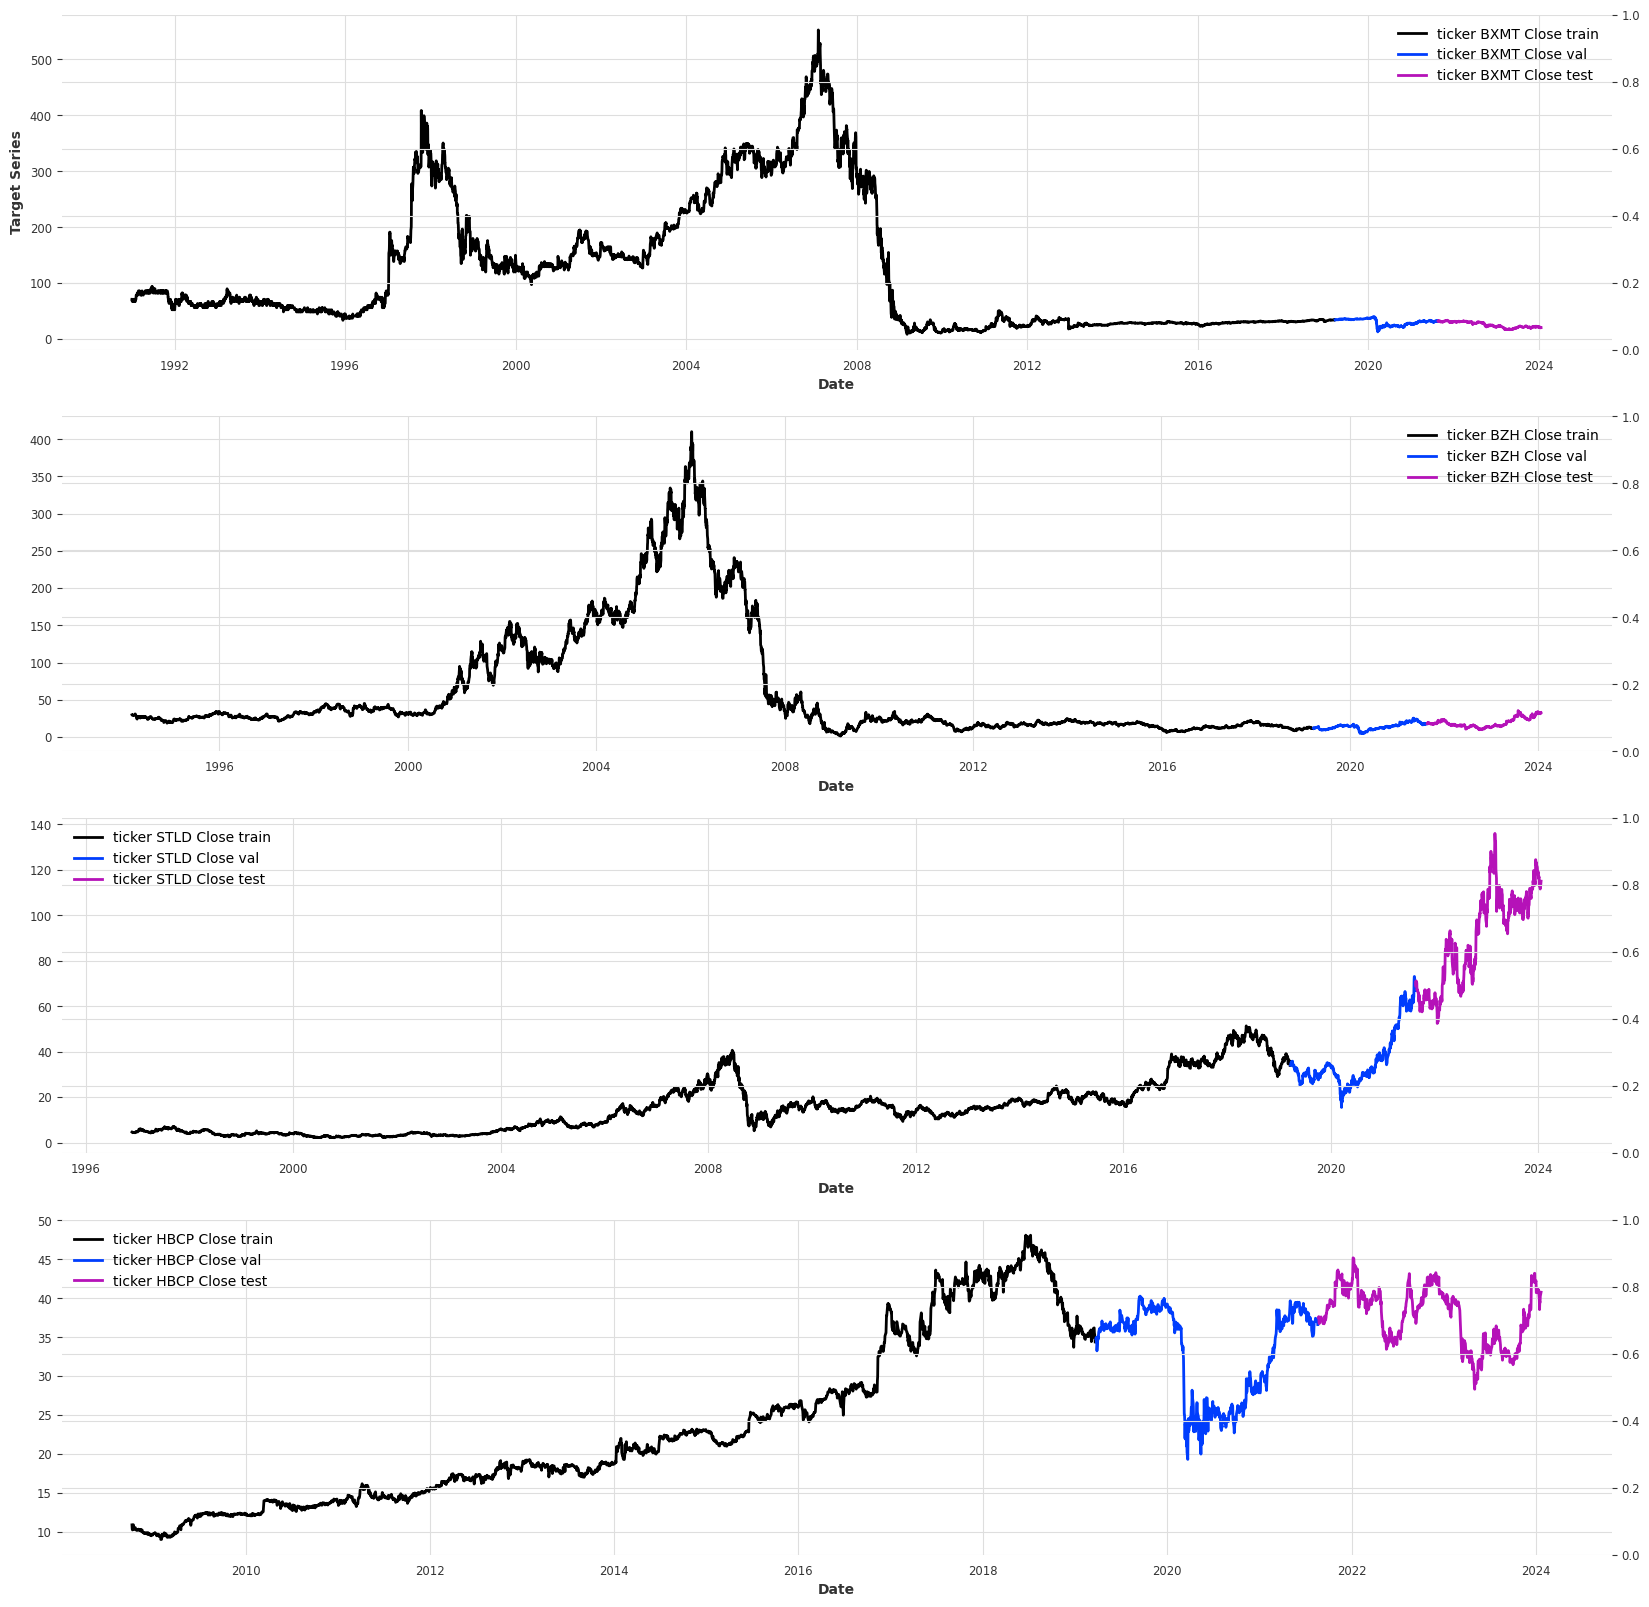

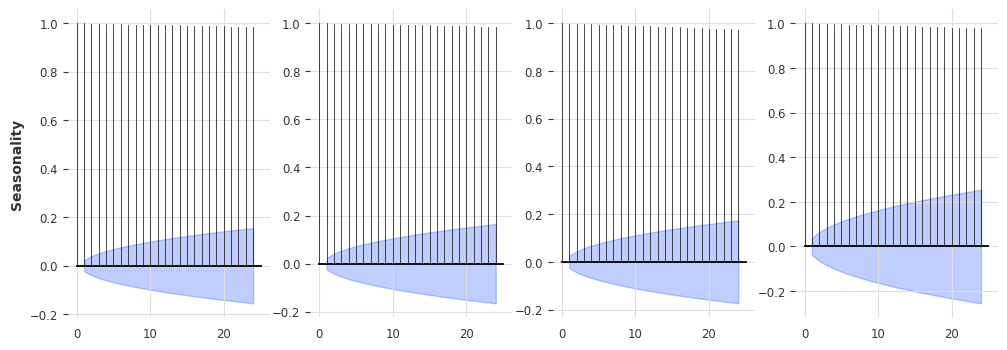

In [34]:
prepare_data()

In [35]:
canswim_model.stock_tickers

['BXMT',
 'BZH',
 'LWLG',
 'STLD',
 'GABC',
 'HBCP',
 'COLL',
 'INTU',
 'HWKN',
 'NOW',
 'PLOW',
 'EVC',
 'GENC',
 'LUMN',
 'TSLX',
 'KAMN',
 'FOLD',
 'ZWS',
 'RELX',
 'CMCL',
 'SAFT',
 'SSTK',
 'XHR',
 'AVD',
 'MLKN',
 'TMP',
 'PSTG',
 'A',
 'HA',
 'ROL',
 'OUT',
 'RYAM',
 'ROG',
 'ASC',
 'ITCI',
 'ENTA',
 'PANW',
 'UFCS',
 'TWOU',
 'BOH',
 'K',
 'EPAC',
 'CDXS',
 'PIPR',
 'BANC',
 'DOV',
 'DNOW',
 'NOC',
 'RHP',
 'WTW']

In [36]:
t = list(canswim_model.targets.target_series.keys())[0]
t

'BXMT'

In [37]:
canswim_model.targets.target_series[t].pd_dataframe()

component,Close
Date,
1991-01-01,71.250000
1991-01-02,71.250000
1991-01-03,67.500000
1991-01-04,67.500000
1991-01-07,67.500000
...,...
2024-01-16,20.809999
2024-01-17,20.160000
2024-01-18,20.150000


In [38]:
future_covs = canswim_model.covariates.future_covariates[t].pd_dataframe().tail(500)
past_covs = canswim_model.covariates.past_covariates[t].pd_dataframe().tail(500)

In [39]:
len(canswim_model.target_train_list)

43

In [40]:
len(canswim_model.past_cov_list)

43

In [41]:
len(canswim_model.future_cov_list)

43

## Find optimal hyper parameters

In [42]:
canswim_model.find_model()


[I 2024-01-27 00:22:31,099] A new study created in memory with name: no-name-a842501a-90cf-4381-908b-271940c331b0


Creating a new model


In [ ]:
# if a model has not been selected and saved yet
# run a hyper parameter search
# otherwise load saved model and continue training
if not canswim_model.load_model():
    # look for an optimal model configuration
    if canswim_model.find_model():
        # if one is found, save it for further training
        canswim_model.save_model()

## Train model

### Run model training loop

In [ ]:

# train loop
for i in range(10):
    # align all data series for training
    canswim_model.train()
    # save model checkpoint
    canswim_model.save()
    # quick test progress at modelcheckpoing
    canswim_model.test()
    canswim_model.plot_test_results()    
    # thorough backtest of model checkpoint
    backtest, test_error = canswim_model.backtest()        
    print(f"Backtest Quantile Loss = {test_error}")
    canswim_model.plot_backtest_results(backtest)    
    # prepare next sample subset
    prepare_data()
